#Project Klasifikasi Malaria CNN

In [1]:
import cv2
import numpy as np 
import pandas as pd 
import os
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.layers import Conv2D,  Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB7
from keras import models
from keras import layers
from classification_models.tfkeras import Classifiers
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
warnings.filterwarnings('ignore')

###1.Preprocessing Data Augmentation

In [ ]:
#data splitting
#import splitfolders

#input_folder = "C:\\Users\Aris\OneDrive\Documents\Malaria_Classification\dataset\cell_images"
#output_folder ="C:\\Users\Aris\OneDrive\Documents\Malaria_Classification\dataset\cell_images\cell_images_75-14-11_splited"
#splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.75,.14,.11),group_prefix=None)

Copying files: 27560 files [01:24, 327.26 files/s]


In [2]:
import os
base_dir = "C:\\Users\Aris\OneDrive\Documents\Malaria_Classification\dataset\cell_images\cell_images_75-14-11_splited"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_parasitized_dir = os.path.join(train_dir, 'Parasitized')
train_uninfected_dir = os.path.join(train_dir, 'Uninfected')

validation_parasitized_dir = os.path.join(validation_dir, 'Parasitized')
validation_uninfected_dir = os.path.join(validation_dir, 'Uninfected')

test_parasitized_dir = os.path.join(test_dir, 'Parasitized')
test_uninfected_dir = os.path.join(test_dir, 'Uninfected')

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=20,                                                             
                                                  target_size=(150, 150),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary', 
    shuffle=False
)

Found 3032 images belonging to 2 classes.
Found 20668 images belonging to 2 classes.
Found 3858 images belonging to 2 classes.


In [ ]:
augmentasi_dir = "C:\\Users\Aris\Documents\Malaria_Classification\dataset\cell_images\Parasitized"
augmentasi_fname = os.listdir(augmentasi_dir)

nrows = 8
ncols = 8

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 8, nrows * 8)

pic_index += 16
next_augmentasi_pix = [os.path.join(augmentasi_dir, fname) 
                for fname in augmentasi_fname[pic_index-16:pic_index]]

for i, img_path in enumerate(next_augmentasi_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

###Parameter Tuning HParam

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                                  featurewise_std_normalization=False,
                                  samplewise_std_normalization=False,
                                  rotation_range=15,
                                  zoom_range=0.1,
                                  horizontal_flip=False,
                                  vertical_flip=False,)

training_set = train_datagen.flow_from_directory("C:\\Users\Aris\OneDrive\Documents\Malaria_Classification\dataset\cell_images\cell_images_75-14-11_splited\\train/",
                                                 target_size=(128,128),
                                                 shuffle=False,
                                                 batch_size = 8,
                                                 class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        featurewise_std_normalization=False,
                                        samplewise_std_normalization=False,
                                        rotation_range=15,
                                        zoom_range=0.1,
                                        horizontal_flip=False,
                                        vertical_flip=False,)

validation_set = validation_datagen.flow_from_directory("C:\\Users\Aris\OneDrive\Documents\Malaria_Classification\dataset\cell_images\cell_images_75-14-11_splited\\val/",
                                                        target_size=(128,128),
                                                        shuffle=False,
                                                        batch_size = 8,
                                                        class_mode='categorical')

Found 20668 images belonging to 2 classes.
Found 3858 images belonging to 2 classes.


In [ ]:
%load_ext tensorboard

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adamax']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
xvl, yvl = zip(*(validation_set[i] for i in range(len(validation_set))))
x_val, y_val = np.vstack(xvl), np.vstack(yvl)

In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
                                      
                                      
                                      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) ,activation=tf.nn.relu , strides = (1,1) , padding = "valid", input_shape
                                      = (150 , 150 , 3), kernel_initializer=glorot_uniform(seed = 2)),
                                      tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
                                      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (4,4) ,activation=tf.nn.relu, strides = (2,2) , padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"),
                                      tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
                                      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) ,activation=tf.nn.relu, strides = (1,1) , padding = "valid" , kernel_initializer = glorot_uniform()),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"),
                                      tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
                                      tf.keras.layers.Conv2D(hparams[HP_NUM_UNITS] , kernel_size = (2,2) , activation=tf.nn.relu, strides = (2,2) , padding = "valid" , kernel_initializer = glorot_uniform()),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.GlobalAveragePooling2D(),
                                      tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
                                                              
                                      tf.keras.layers.Flatten(),

                                      tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                      tf.keras.layers.Dense(2, activation=tf.nn.softmax),
                                      ])

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(training_set, 
            validation_data=validation_set, 
            epochs=25,
            )
  _, accuracy = model.evaluate(x_val, y_val)
  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=50)

In [ ]:
['adam', 'sgd', 'adadelta', 'adamax', 'nadam', 'rmsprop']

['adam', 'sgd', 'adadelta', 'adamax', 'nadam', 'rmsprop']

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning_malaria/' + run_name, hparams)
      session_num += 1

In [ ]:
%%bash
wget -q 'https://storage.googleapis.com/download.tensorflow.org/tensorboard/hparams_demo_logs.zip'
unzip -q hparams_demo_logs.zip -d logs/hparam_demo

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!kill 5496

###Model 1 Max Pooling CNN

In [ ]:
#Model 1 3 Layer 32-64-128
model1 = Sequential()
model1.add(InputLayer(input_shape=[150, 150, 3]))
model1.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(SpatialDropout2D(rate=0.5))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=2, padding='same'))

model1.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(SpatialDropout2D(rate=0.5))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=2, padding='same'))

model1.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model1.add(SpatialDropout2D(rate=0.5))
model1.add(BatchNormalization())
model1.add(GlobalMaxPool2D())

model1.add(Flatten())

# fully connected
model1.add(Dense(512, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 150, 150, 32)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        18496     
                                                      

In [ ]:
from tensorflow.keras.optimizers import Adam

#Compile model
model1.compile(loss='binary_crossentropy', 
               optimizer=Adam(learning_rate = 0.0001),
               metrics=['acc'] )

In [ ]:
H = model1.fit(train_generator ,steps_per_epoch=180, epochs=106, validation_data= validation_generator)

Epoch 1/106
180/180 [==============================] - 10s 35ms/step - loss: 1.1209 - acc: 0.4983 - val_loss: 0.6937 - val_acc: 0.4917
Epoch 2/106
180/180 [==============================] - 6s 32ms/step - loss: 0.8846 - acc: 0.5008 - val_loss: 0.6943 - val_acc: 0.4670
Epoch 3/106
180/180 [==============================] - 6s 31ms/step - loss: 0.8395 - acc: 0.4969 - val_loss: 0.6928 - val_acc: 0.5058
Epoch 4/106
180/180 [==============================] - 6s 31ms/step - loss: 0.8364 - acc: 0.4822 - val_loss: 0.6937 - val_acc: 0.5004
Epoch 5/106
180/180 [==============================] - 6s 32ms/step - loss: 0.8055 - acc: 0.4919 - val_loss: 0.6911 - val_acc: 0.5065
Epoch 6/106
180/180 [==============================] - 6s 32ms/step - loss: 0.7849 - acc: 0.5083 - val_loss: 0.6903 - val_acc: 0.5287
Epoch 7/106
180/180 [==============================] - 6s 31ms/step - loss: 0.7957 - acc: 0.4919 - val_loss: 0.6904 - val_acc: 0.5356
Epoch 8/106
180/180 [==============================] - 6s 31m

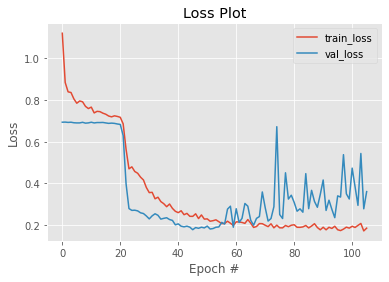

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 106), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

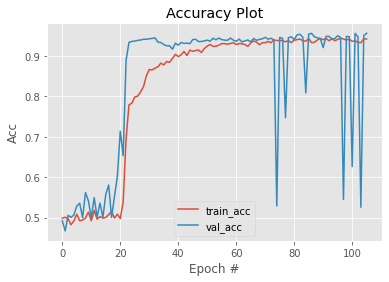

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 106), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9531930333817126
Precision : 0.9532703733355807
f1Score : 0.9531910366688909
[[2609  147]
 [ 111 2645]]


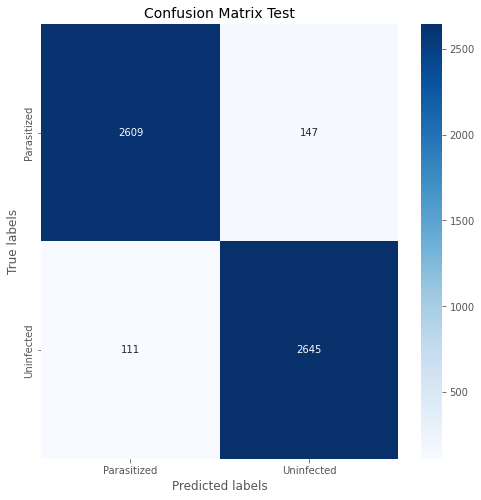

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model1.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2756
           1       0.95      0.96      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9531930333817127


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9531930333817127


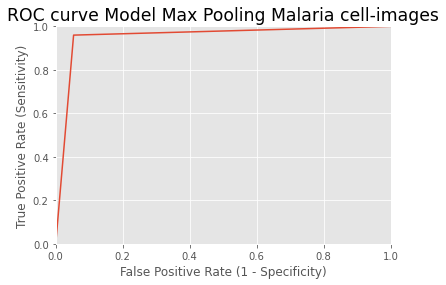

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Max Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model1.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model1MaxACC95.h5")

###Model 2 Avg Pooling CNN

In [ ]:
#Model 2 Avg Pooling 4 layer 
model2 = Sequential()
model2.add(Conv2D(filters = 32 , kernel_size = (3,3) ,activation='relu' , strides = (1,1) , padding = "valid", input_shape
                  = (150 , 150 , 3), kernel_initializer=glorot_uniform(seed = 2) ))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 32 , kernel_size = (4,4) ,activation='relu', strides = (2,2) , padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 64 , kernel_size = (3,3) ,activation='relu', strides = (1,1) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 128 , kernel_size = (2,2) , activation='relu', strides = (2,2) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(.2))

model2.add(Flatten())
# fully connected
model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 32)        16416     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 36, 36, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

In [ ]:
from tensorflow.keras.optimizers import Adam

#Compile model
model2.compile(loss='binary_crossentropy', 
               optimizer=Adam(learning_rate = 0.0001),
               metrics=['acc'] )

In [ ]:
H = model2.fit(train_generator ,steps_per_epoch=180, epochs=106, validation_data= validation_generator)

Epoch 1/106
180/180 [==============================] - 9s 31ms/step - loss: 0.6334 - acc: 0.6506 - val_loss: 0.7547 - val_acc: 0.5000
Epoch 2/106
180/180 [==============================] - 5s 29ms/step - loss: 0.6249 - acc: 0.6656 - val_loss: 1.2650 - val_acc: 0.5022
Epoch 3/106
180/180 [==============================] - 5s 29ms/step - loss: 0.5679 - acc: 0.7217 - val_loss: 1.6693 - val_acc: 0.5076
Epoch 4/106
180/180 [==============================] - 5s 29ms/step - loss: 0.4714 - acc: 0.7956 - val_loss: 0.8742 - val_acc: 0.5798
Epoch 5/106
180/180 [==============================] - 5s 30ms/step - loss: 0.4160 - acc: 0.8237 - val_loss: 0.4174 - val_acc: 0.8364
Epoch 6/106
180/180 [==============================] - 5s 30ms/step - loss: 0.3496 - acc: 0.8681 - val_loss: 0.5160 - val_acc: 0.8059
Epoch 7/106
180/180 [==============================] - 6s 31ms/step - loss: 0.2518 - acc: 0.9161 - val_loss: 0.5025 - val_acc: 0.8175
Epoch 8/106
180/180 [==============================] - 5s 29ms

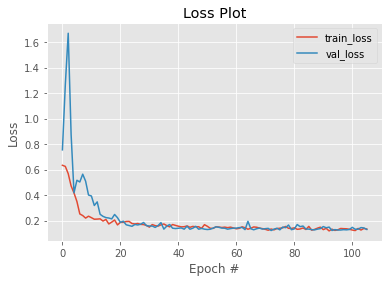

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 106), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

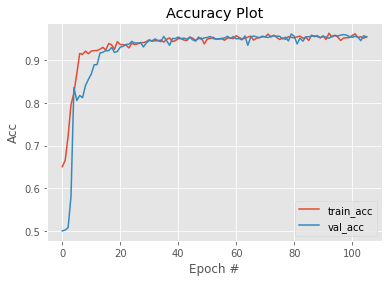

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 106), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9559143686502177
Precision : 0.9570770496877398
f1Score : 0.9558863153139615
[[2565  191]
 [  52 2704]]


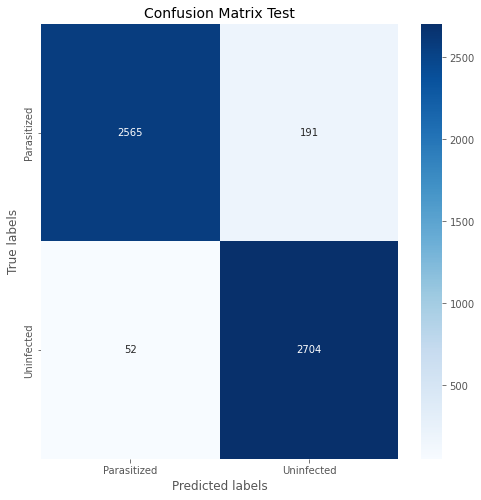

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model2.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2756
           1       0.93      0.98      0.96      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9559143686502177


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9559143686502177


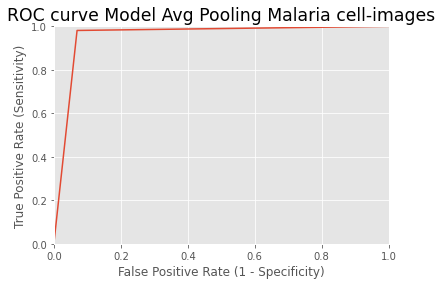

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model2.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model2AvgACC96.h5")

###Model 3 Avg Pooling CNN + Augmentation

In [ ]:
#Model 2 Avg Pooling 4 layer 
model2 = Sequential()
model2.add(Conv2D(filters = 32 , kernel_size = (3,3) ,activation='relu' , strides = (1,1) , padding = "valid", input_shape
                  = (150 , 150 , 3), kernel_initializer=glorot_uniform(seed = 2) ))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 32 , kernel_size = (4,4) ,activation='relu', strides = (2,2) , padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 64 , kernel_size = (3,3) ,activation='relu', strides = (1,1) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 128 , kernel_size = (2,2) , activation='relu', strides = (2,2) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(.2))

model2.add(Flatten())
# fully connected
model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 32)        16416     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 36, 36, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

In [ ]:
from tensorflow.keras.optimizers import Adam

#Compile model
model2.compile(loss='binary_crossentropy', 
               optimizer=Adam(learning_rate = 0.0001),
               metrics=['acc'] )

In [ ]:
H = model2.fit(train_generator ,steps_per_epoch=180, epochs=106, validation_data= validation_generator)

Epoch 1/106
180/180 [==============================] - 33s 164ms/step - loss: 0.6391 - acc: 0.6381 - val_loss: 0.6761 - val_acc: 0.6350
Epoch 2/106
180/180 [==============================] - 30s 164ms/step - loss: 0.6295 - acc: 0.6500 - val_loss: 0.6567 - val_acc: 0.6176
Epoch 3/106
180/180 [==============================] - 30s 164ms/step - loss: 0.6131 - acc: 0.6792 - val_loss: 0.6640 - val_acc: 0.6168
Epoch 4/106
180/180 [==============================] - 30s 169ms/step - loss: 0.5597 - acc: 0.7364 - val_loss: 0.5996 - val_acc: 0.6930
Epoch 5/106
180/180 [==============================] - 30s 168ms/step - loss: 0.5065 - acc: 0.7742 - val_loss: 0.5325 - val_acc: 0.6785
Epoch 6/106
180/180 [==============================] - 30s 166ms/step - loss: 0.4656 - acc: 0.7964 - val_loss: 0.4937 - val_acc: 0.7264
Epoch 7/106
180/180 [==============================] - 29s 163ms/step - loss: 0.4129 - acc: 0.8267 - val_loss: 0.6254 - val_acc: 0.5570
Epoch 8/106
180/180 [===========================

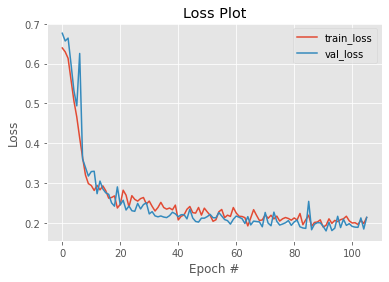

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 106), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

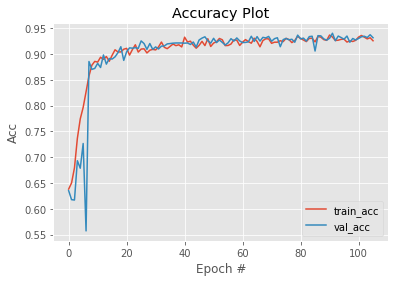

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 106), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9521044992743106
Precision : 0.9532081129306432
f1Score : 0.9520753237555648
[[2556  200]
 [  64 2692]]


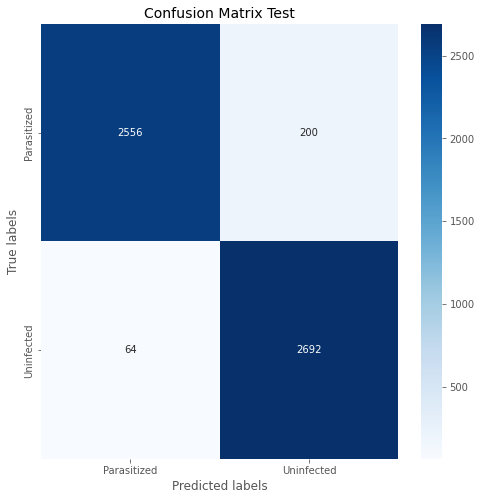

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model2.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2756
           1       0.93      0.98      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9521044992743106


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9521044992743106


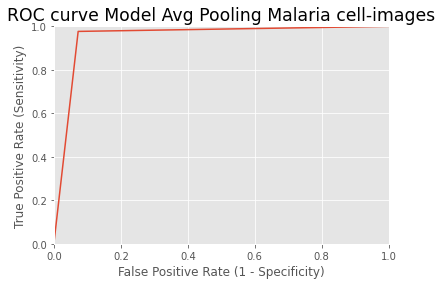

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model2.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model2AvgACC95.h5")

###Model 4 Avg Pooling CNN + Augmentation + Adamax 3e-4

In [ ]:
#Model 2 Avg Pooling 4 layer 
model2 = Sequential()
model2.add(Conv2D(filters = 32 , kernel_size = (3,3) ,activation='swish' , strides = (1,1) , padding = "valid", input_shape
                  = (150 , 150 , 3), kernel_initializer=glorot_uniform(seed = 2) ))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 32 , kernel_size = (4,4) ,activation='swish', strides = (2,2) , padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 64 , kernel_size = (3,3) ,activtion='swish', strides = (1,1) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 128 , kernel_size = (2,2) , activation='swish', strides = (2,2) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))

model2.add(Flatten())
# fully connected
model2.add(Dense(512, activation='swish'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 32)        16416     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 36, 36, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

In [ ]:
from tensorflow.keras.optimizers import SGD

#Compile model
model2.compile(loss='binary_crossentropy',                optimizer=SGD(learning_rate = 1e-4, decay=1e-5),
               metrics=['acc'] )

In [ ]:
H = model2.fit(train_generator ,steps_per_epoch=180, epochs=106, validation_data= validation_generator)

Epoch 1/106
180/180 [==============================] - 38s 192ms/step - loss: 0.7636 - acc: 0.6186 - val_loss: 0.6895 - val_acc: 0.5000
Epoch 2/106
180/180 [==============================] - 33s 186ms/step - loss: 0.6484 - acc: 0.6631 - val_loss: 0.6604 - val_acc: 0.6216
Epoch 3/106
180/180 [==============================] - 33s 184ms/step - loss: 0.5718 - acc: 0.7120 - val_loss: 0.6549 - val_acc: 0.6118
Epoch 4/106
180/180 [==============================] - 33s 183ms/step - loss: 0.4387 - acc: 0.8053 - val_loss: 0.7140 - val_acc: 0.7043
Epoch 5/106
180/180 [==============================] - 33s 185ms/step - loss: 0.3452 - acc: 0.8592 - val_loss: 0.4391 - val_acc: 0.8244
Epoch 6/106
180/180 [==============================] - 33s 183ms/step - loss: 0.3141 - acc: 0.8749 - val_loss: 0.4316 - val_acc: 0.8440
Epoch 7/106
180/180 [==============================] - 34s 189ms/step - loss: 0.2864 - acc: 0.8958 - val_loss: 0.3447 - val_acc: 0.8810
Epoch 8/106
180/180 [===========================

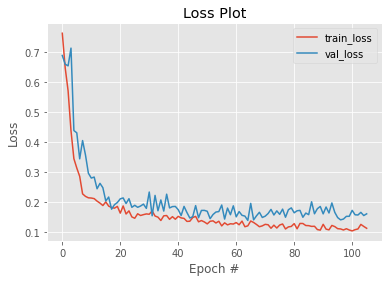

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 106), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

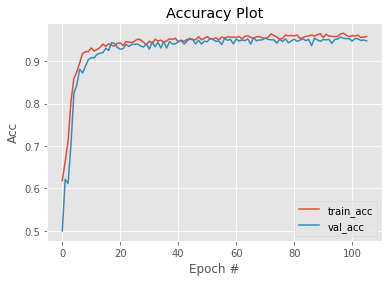

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 106), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 106), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9559143686502177
Precision : 0.9572508676824676
f1Score : 0.9558821306087433
[[2560  196]
 [  47 2709]]


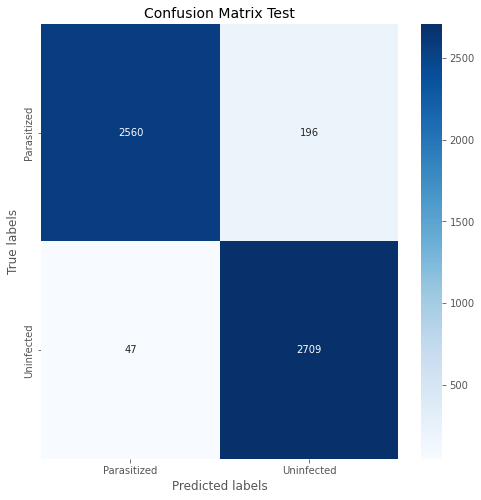

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model2.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2756
           1       0.93      0.98      0.96      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9559143686502177


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9559143686502178


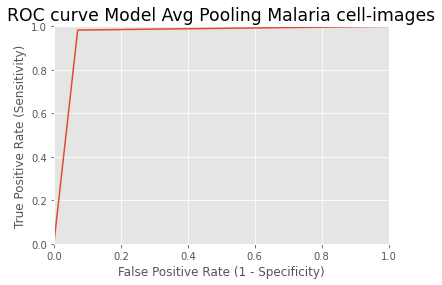

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model2.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model2AvgACC96.h5")

###Model 5 Avg Pooling CNN + Augmentation Parameter Tuning

In [ ]:
#Model 2 Avg Pooling 4 layer 
model2 = Sequential()
model2.add(Conv2D(filters = 32 , kernel_size = (3,3) ,activation='relu' , strides = (1,1) , padding = "valid", input_shape
                  = (150 , 150 , 3), kernel_initializer=glorot_uniform(seed = 2) ))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 64 , kernel_size = (4,4) ,activation='relu', strides = (2,2) , padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 128 , kernel_size = (3,3) ,activation='relu', strides = (1,1) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 256 , kernel_size = (2,2) , activation='relu', strides = (2,2) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(.2))

model2.add(Flatten())
# fully connected
model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 64)        32832     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 64)       256       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 36, 36, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [ ]:
from tensorflow.keras.optimizers import Adamax

#Compile model
model2.compile(loss='binary_crossentropy', 
               optimizer=Adamax(learning_rate = 2e-4, decay=2e-4/20),
               metrics=['acc'] )

In [ ]:
H = model2.fit(train_generator,batch_size=20 , epochs=50, validation_data= validation_generator)

Epoch 1/50
1034/1034 [==============================] - 136s 132ms/step - loss: 0.5790 - acc: 0.7059 - val_loss: 0.7704 - val_acc: 0.6006
Epoch 2/50
1034/1034 [==============================] - 127s 123ms/step - loss: 0.3958 - acc: 0.8361 - val_loss: 0.3242 - val_acc: 0.8634
Epoch 3/50
1034/1034 [==============================] - 127s 123ms/step - loss: 0.2790 - acc: 0.8946 - val_loss: 0.4469 - val_acc: 0.8491
Epoch 4/50
1034/1034 [==============================] - 127s 123ms/step - loss: 0.2482 - acc: 0.9099 - val_loss: 0.3312 - val_acc: 0.8854
Epoch 5/50
1034/1034 [==============================] - 127s 123ms/step - loss: 0.2245 - acc: 0.9196 - val_loss: 0.2052 - val_acc: 0.9225
Epoch 6/50
1034/1034 [==============================] - 127s 123ms/step - loss: 0.2149 - acc: 0.9253 - val_loss: 0.1961 - val_acc: 0.9256
Epoch 7/50
1034/1034 [==============================] - 127s 123ms/step - loss: 0.2108 - acc: 0.9269 - val_loss: 0.1850 - val_acc: 0.9308
Epoch 8/50
1034/1034 [============

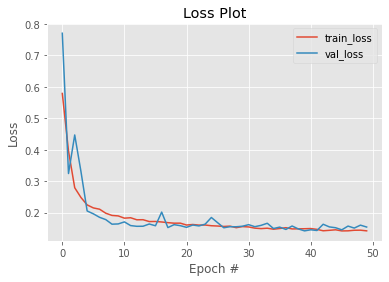

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

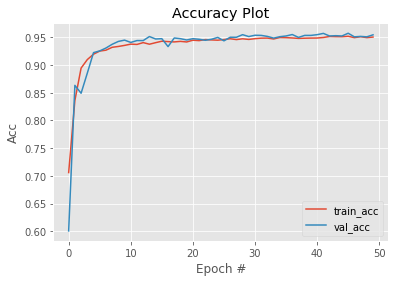

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9564643799472295
Precision : 0.9568492196209588
f1Score : 0.9564552096552661
[[1428   88]
 [  44 1472]]


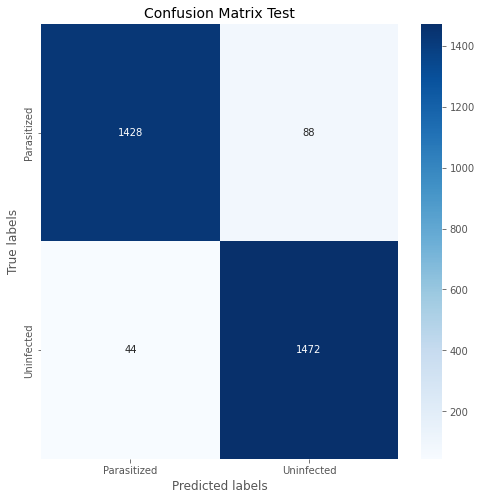

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model2.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1516
           1       0.94      0.97      0.96      1516

    accuracy                           0.96      3032
   macro avg       0.96      0.96      0.96      3032
weighted avg       0.96      0.96      0.96      3032



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9564643799472295


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9564643799472294


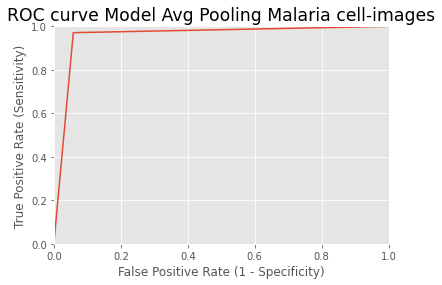

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model2.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model2AvgACC95.h5")

###Model 6 Avg Pooling CNN + Augmentation Parameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self._name__ = 'Mish'

def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish' : Mish(mish)})

In [ ]:
#Model 2 Avg Pooling 4 layer 
model2 = Sequential()
model2.add(Conv2D(filters = 32 , kernel_size = (3,3) ,activation='Mish' , strides = (1,1) , padding = "valid", input_shape
                  = (150 , 150 , 3), kernel_initializer=glorot_uniform(seed = 2) ))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 64 , kernel_size = (4,4) ,activation='Mish', strides = (2,2) , padding = "valid" , kernel_initializer=glorot_uniform(seed = 2)))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 128 , kernel_size = (3,3) ,activation='Mish', strides = (1,1) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2,2) , strides = (2,2) , padding = "valid"))
model2.add(Dropout(.2))
model2.add(Conv2D(filters = 256 , kernel_size = (2,2) , activation='Mish', strides = (2,2) , padding = "valid" , kernel_initializer = glorot_uniform()))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(.2))

model2.add(Flatten())
# fully connected
model2.add(Dense(512, activation='Mish'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 dropout_8 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 73, 73, 64)        32832     
                                                                 
 batch_normalization_6 (Batc  (None, 73, 73, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 36, 36, 64)       0         
 ePooling2D)                                                     
                                                                 
 dropout_9 (Dropout)         (None, 36, 36, 64)       

In [ ]:
from tensorflow.keras.optimizers import Adamax

#Compile model
model2.compile(loss='binary_crossentropy', 
               optimizer=Adamax(learning_rate = 3e-4, decay=3e-4/20),
               metrics=['acc'] )

In [ ]:
H = model2.fit(train_generator , batch_size=20, epochs=50, validation_data= validation_generator)

Epoch 1/50
1034/1034 [==============================] - 136s 130ms/step - loss: 0.6000 - acc: 0.6822 - val_loss: 0.5583 - val_acc: 0.6962
Epoch 2/50
1034/1034 [==============================] - 133s 128ms/step - loss: 0.3557 - acc: 0.8606 - val_loss: 0.4807 - val_acc: 0.8375
Epoch 3/50
1034/1034 [==============================] - 132s 128ms/step - loss: 0.2733 - acc: 0.8969 - val_loss: 0.3057 - val_acc: 0.8844
Epoch 4/50
1034/1034 [==============================] - 131s 126ms/step - loss: 0.2481 - acc: 0.9079 - val_loss: 0.2631 - val_acc: 0.9101
Epoch 5/50
1034/1034 [==============================] - 128s 124ms/step - loss: 0.2346 - acc: 0.9174 - val_loss: 0.2064 - val_acc: 0.9292
Epoch 6/50
1034/1034 [==============================] - 128s 124ms/step - loss: 0.2258 - acc: 0.9190 - val_loss: 0.2389 - val_acc: 0.9134
Epoch 7/50
1034/1034 [==============================] - 129s 124ms/step - loss: 0.2203 - acc: 0.9229 - val_loss: 0.2450 - val_acc: 0.9067
Epoch 8/50
1034/1034 [============

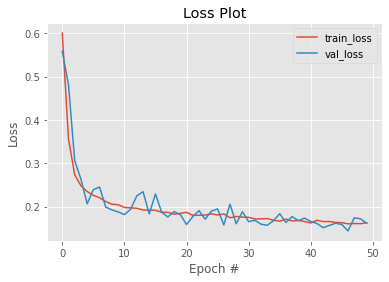

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

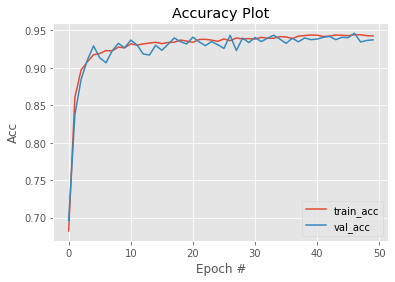

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9521767810026385
Precision : 0.9531154417166814
f1Score : 0.952152000873288
[[1409  107]
 [  38 1478]]


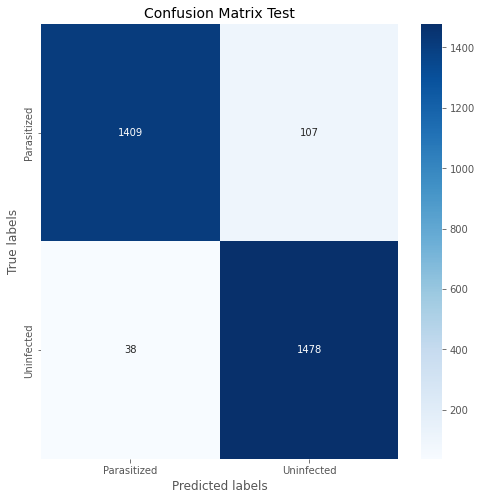

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model2.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1516
           1       0.93      0.97      0.95      1516

    accuracy                           0.95      3032
   macro avg       0.95      0.95      0.95      3032
weighted avg       0.95      0.95      0.95      3032



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9521767810026385


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9521767810026385


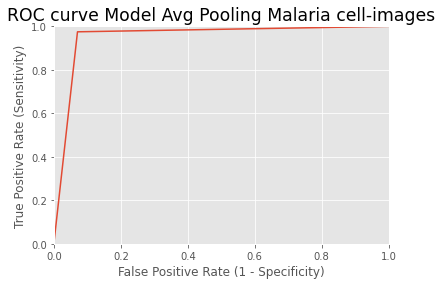

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model2.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model2AvgACC95.h5")

###Model 7 PreTrain ResNet50 + Augmentation Parameter Tuning

In [ ]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=(150,150,3))
model=Sequential()
model.add(resnet_model)
model.trainable = True

# Freeze all layers except for 
for layer in model.layers[:-26]:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(768,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                        

In [ ]:
from tensorflow.keras.optimizers import Adamax

#Compile model
model.compile(loss='binary_crossentropy', 
               optimizer=Adamax(learning_rate = 2e-4, decay=2e-4/20),
               metrics=['acc'] )

In [ ]:
H = model.fit(train_generator,batch_size=20 , epochs=100, steps_per_epoch=180, validation_data= validation_generator)

Epoch 1/100
180/180 [==============================] - 49s 221ms/step - loss: 0.3896 - acc: 0.8417 - val_loss: 1.1371 - val_acc: 0.5000
Epoch 2/100
180/180 [==============================] - 38s 213ms/step - loss: 0.2617 - acc: 0.9094 - val_loss: 1.5811 - val_acc: 0.5000
Epoch 3/100
180/180 [==============================] - 38s 212ms/step - loss: 0.2048 - acc: 0.9303 - val_loss: 2.0069 - val_acc: 0.5000
Epoch 4/100
180/180 [==============================] - 38s 213ms/step - loss: 0.2251 - acc: 0.9322 - val_loss: 1.6380 - val_acc: 0.5023
Epoch 5/100
180/180 [==============================] - 40s 223ms/step - loss: 0.1936 - acc: 0.9367 - val_loss: 0.6261 - val_acc: 0.7289
Epoch 6/100
180/180 [==============================] - 41s 227ms/step - loss: 0.1886 - acc: 0.9331 - val_loss: 0.2003 - val_acc: 0.9357
Epoch 7/100
180/180 [==============================] - 41s 225ms/step - loss: 0.1946 - acc: 0.9369 - val_loss: 0.1222 - val_acc: 0.9588
Epoch 8/100
180/180 [===========================

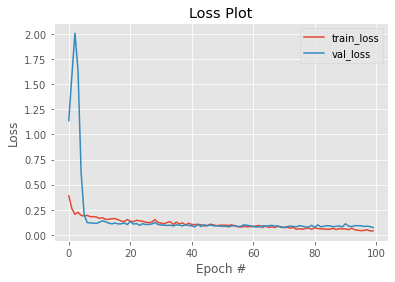

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

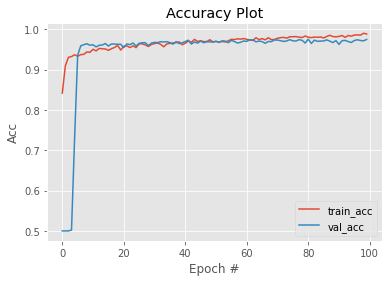

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9693271767810027
Precision : 0.9696069070877235
f1Score : 0.9693226083877169
[[1451   65]
 [  28 1488]]


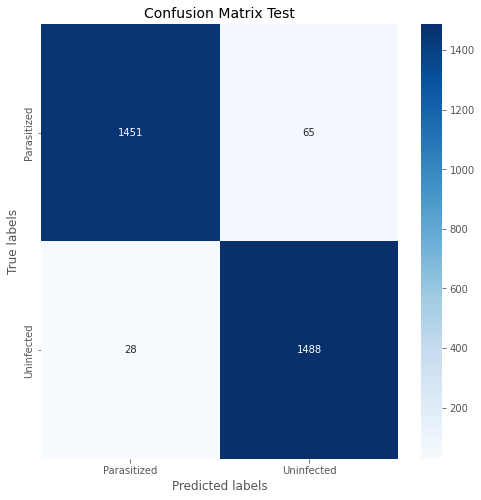

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1516
           1       0.96      0.98      0.97      1516

    accuracy                           0.97      3032
   macro avg       0.97      0.97      0.97      3032
weighted avg       0.97      0.97      0.97      3032



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9693271767810026


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9693271767810027


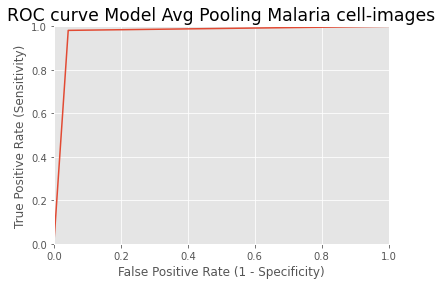

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model7ResNet50.h5")

In [ ]:
#tflite model
TF_LITE_MODEL_FILE_NAME = 'C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\tf_lite_ResNet50.tflite'

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Aris\AppData\Local\Temp\tmpr55ro7nw\assets


INFO:tensorflow:Assets written to: C:\Users\Aris\AppData\Local\Temp\tmpr55ro7nw\assets


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

148514616

###Model 8 PreTrain Xception + Augmentation Parameter Tuning

In [ ]:
resnet_model = Xception(weights='imagenet',include_top=False,input_shape=(150,150,3))
model=Sequential()
model.add(resnet_model)
model.trainable = True

# Freeze all layers except for 
for layer in model.layers[:-21]:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(768,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                        

In [ ]:
from tensorflow.keras.optimizers import Adamax

#Compile model
model.compile(loss='binary_crossentropy', 
               optimizer=Adamax(learning_rate = 3e-4, decay=3e-4/20),
               metrics=['acc'] )

In [ ]:
H = model.fit(train_generator,batch_size=20 , epochs=100, steps_per_epoch=180, validation_data= validation_generator)

Epoch 1/100
180/180 [==============================] - 52s 245ms/step - loss: 0.4539 - acc: 0.8236 - val_loss: 0.1719 - val_acc: 0.9450
Epoch 2/100
180/180 [==============================] - 43s 237ms/step - loss: 0.2505 - acc: 0.9158 - val_loss: 0.1448 - val_acc: 0.9554
Epoch 3/100
180/180 [==============================] - 42s 234ms/step - loss: 0.2135 - acc: 0.9331 - val_loss: 0.1368 - val_acc: 0.9567
Epoch 4/100
180/180 [==============================] - 43s 237ms/step - loss: 0.2279 - acc: 0.9333 - val_loss: 0.1286 - val_acc: 0.9585
Epoch 5/100
180/180 [==============================] - 44s 242ms/step - loss: 0.2227 - acc: 0.9250 - val_loss: 0.1235 - val_acc: 0.9601
Epoch 6/100
180/180 [==============================] - 43s 238ms/step - loss: 0.2148 - acc: 0.9272 - val_loss: 0.1363 - val_acc: 0.9557
Epoch 7/100
180/180 [==============================] - 42s 236ms/step - loss: 0.1833 - acc: 0.9422 - val_loss: 0.1133 - val_acc: 0.9601
Epoch 8/100
180/180 [===========================

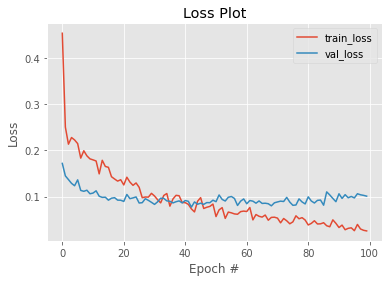

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

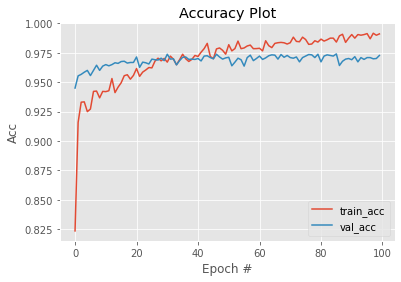

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9686675461741425
Precision : 0.9687134333696978
f1Score : 0.9686667792910515
[[1476   40]
 [  55 1461]]


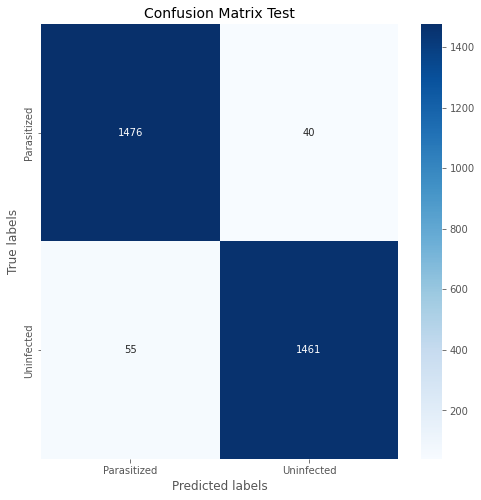

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1516
           1       0.97      0.96      0.97      1516

    accuracy                           0.97      3032
   macro avg       0.97      0.97      0.97      3032
weighted avg       0.97      0.97      0.97      3032



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9686675461741425


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9686675461741425


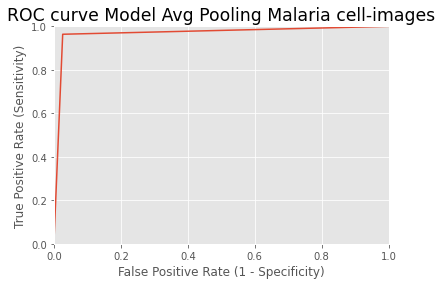

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model8Xception.h5")

In [ ]:
#tflite model
TF_LITE_MODEL_FILE_NAME = 'C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\tf_lite_Xception.tflite'

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Aris\AppData\Local\Temp\tmpfj83tlo_\assets


INFO:tensorflow:Assets written to: C:\Users\Aris\AppData\Local\Temp\tmpfj83tlo_\assets


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

137714848

###Model 9 PreTrain EfficientNetB7 + Augmentation Parameter Tuning

In [5]:
resnet_model = EfficientNetB7(weights='imagenet',include_top=False,input_shape=(150,150,3))
model=Sequential()
model.add(resnet_model)
model.trainable = True

# Freeze all layers except for 
for layer in model.layers[:-16]:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(768,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

258076736/258076736 [==============================] - 85s 0us/step


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense (Dense)               (None, 256)               16384256  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                        

In [7]:
from tensorflow.keras.optimizers import Adamax

#Compile model
model.compile(loss='binary_crossentropy', 
               optimizer=Adamax(learning_rate = 3e-4, decay=3e-4/20),
               metrics=['acc'] )

In [ ]:
H = model.fit(train_generator,batch_size=20 , epochs=100, steps_per_epoch=180, validation_data= validation_generator)

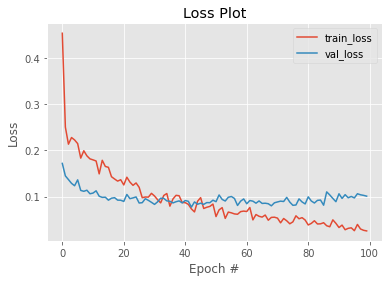

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

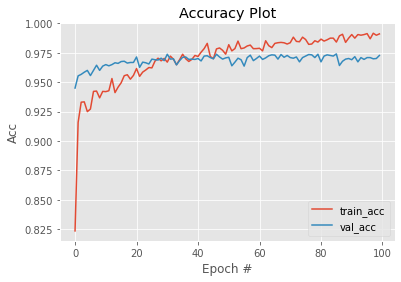

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy  : 0.9686675461741425
Precision : 0.9687134333696978
f1Score : 0.9686667792910515
[[1476   40]
 [  55 1461]]


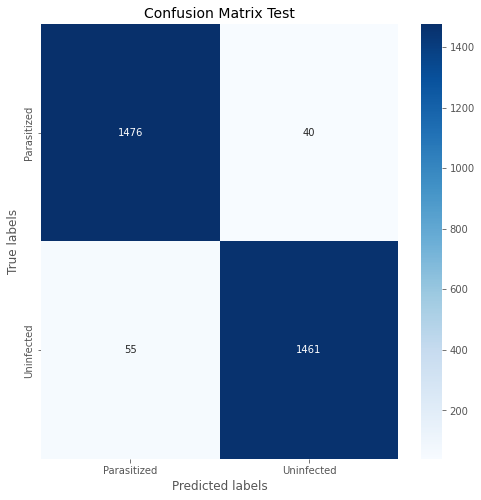

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, f1_score
import seaborn as sns
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

batch_size=16


predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, yPredictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1516
           1       0.97      0.96      0.97      1516

    accuracy                           0.97      3032
   macro avg       0.97      0.97      0.97      3032
weighted avg       0.97      0.97      0.97      3032



In [ ]:
#Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(true_classes, yPredictions))

0.9686675461741425


In [ ]:
#ROC AUC Score
from sklearn.metrics import  roc_auc_score
print(roc_auc_score(true_classes, yPredictions))

0.9686675461741425


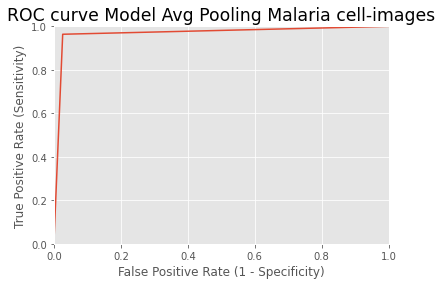

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_classes, yPredictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve Model Avg Pooling Malaria cell-images')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
model.save("C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\Model8Xception.h5")

In [ ]:
#tflite model
TF_LITE_MODEL_FILE_NAME = 'C:\\Users\\Aris\\Documents\\Malaria_Classification\\model\\tf_lite_Xception.tflite'

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Aris\AppData\Local\Temp\tmpfj83tlo_\assets


INFO:tensorflow:Assets written to: C:\Users\Aris\AppData\Local\Temp\tmpfj83tlo_\assets


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

137714848